In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
#export
from exp.nb_04 import *

## Initial setup

In [3]:
x_train, y_train, x_valid, y_valid = get_data()

In [4]:
train_ds, valid_ds = Dataset(x_train, y_train), Dataset(x_valid, y_valid)

In [5]:
nh, bs = 50, 512
c = y_train.max().item() + 1

In [6]:
loss_func = F.cross_entropy

In [7]:
#export 
def create_learner(model_func, loss_func, data):
    return Learner(*model_func(data), loss_func, data)

In [8]:
data = DataBunch(*get_dls(train_ds, valid_ds, bs), c)

In [9]:
learn = create_learner(get_model, loss_func, data)

run = Runner([AvgStatsCallback([accuracy])])

run.fit(3, learn)

train: [0.6815903125, tensor(0.7993)]
valid: [0.3190770751953125, tensor(0.9057)]
train: [0.29727869140625, tensor(0.9132)]
valid: [0.23265205078125, tensor(0.9338)]
train: [0.2372449609375, tensor(0.9326)]
valid: [0.2023166259765625, tensor(0.9406)]


In [10]:
learn = create_learner(partial(get_model, lr=0.3), loss_func, data)

run = Runner([AvgStatsCallback([accuracy])])

run.fit(3, learn)

train: [0.752780546875, tensor(0.8062)]
valid: [0.3433801025390625, tensor(0.9065)]
train: [0.341501953125, tensor(0.9023)]
valid: [0.289887255859375, tensor(0.9175)]
train: [0.29181935546875, tensor(0.9164)]
valid: [0.2604709716796875, tensor(0.9247)]


In [11]:
#export
def get_model_func(lr=0.5):
    return partial(get_model, lr=lr)

# Annealing
We define two callbacks:

1. `Recorder`: keeps track of the loss and scheduled learning rate.
2. `ParamScheduler`: schedules any hyperparameter as long as it is registered in the state_dict of the optimizer.

In [12]:
#export
class Recorder(Callback):
    def begin_fit(self):
        self.lrs, self.losses = [], []
        
    def after_batch(self):
        if not self.in_train: return
        self.lrs.append(self.opt.param_groups[-1]['lr'])  # self.opt delegates to runner which delegates to learn
        self.losses.append(self.loss.detach().cpu())      # self.loss belongs to runner
    
    def plot_lr(self): plt.plot(self.lrs)
    def plot_loss(self): plt.plot(self.losses)

class ParamScheduler(Callback):
    _order = 1
    def __init__(self, pname, sched_func):
        self.pname, self.sched_func = pname, sched_func
    
    def set_param(self):
        for pg in self.opt.param_groups:
            pg[self.pname] = self.sched_func(self.n_epochs/self.epochs)  
            # self.n_epochs=1.5 means we arrived at half of second epoch, self.epochs = total num of epochs
            
    def begin_batch(self):
        if self.in_train: self.set_param()

Let's start with a simple schedule that linearly goes from `start` to `end`:

In [13]:
def sched_lin(start, end):
    def _inner(start, end, pos): return start + pos*(end - start)
    return partial(_inner, start, end)

The function that is returned takes a single argument `pos`:

In [14]:
test_sched_func = sched_lin(0.,1.)

In [15]:
test_sched_func(0.5)

0.5

Let's refactor this with a decorator:

In [16]:
#export
def annealer(f):
    def _inner(start, end): return partial(f, start, end)
    return _inner

In [17]:
#export
@annealer
def sched_lin(start, end, pos): return start + pos*(end - start)

In [18]:
test_sched_func = sched_lin(0., 1.)  # check with shift-tab: requires start and end

In [19]:
test_sched_func(0.5)                 # check with shift-tab: requires pos

0.5

Other schedulers:

In [20]:
#export
@annealer
def sched_cos(start, end, pos): return start + (1 + math.cos(math.pi*(1-pos))) * (end-start) / 2

@annealer
def sched_no(start, end, pos):  return start

@annealer
def sched_exp(start, end, pos): return start * (end/start) ** pos

To fix `AttributeError: 'Tensor' object has no attribute 'ndim'`:


In [21]:
#export
torch.Tensor.ndim = property(lambda x: len(x.shape))

In [22]:
annealings = "NO LINEAR COS EXP".split()

In [23]:
a = torch.arange(0, 100)
p = torch.linspace(0.01, 1, 100)

In [24]:
fns = [sched_no, sched_lin, sched_cos, sched_exp]

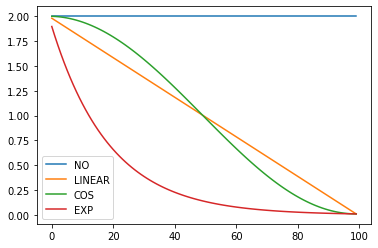

In [25]:
for fn, t in zip(fns, annealings):
    f = fn(2, 1e-2)
    plt.plot(a, [f(o) for o in p], label=t)
plt.legend();

We can also combine several schedulers. Let's build ony-cycle learning rate scheduling:

In [26]:
#export
def combine_scheds(pcts, scheds):
    assert sum(pcts) == 1.
    pcts = tensor([0] + listify(pcts))
    assert torch.all(pcts >= 0)
    pcts = torch.cumsum(pcts, 0)  # performs an inclusive prefix sum/scan along dimension 0
    def _inner(pos):
        #pdb.set_trace()
        idx = (pos >= pcts).nonzero().max()
        actual_pos = (pos - pcts[idx]) / (pcts[idx + 1] - pcts[idx])
        return scheds[idx](actual_pos)
    return _inner

For the first 30% inrease the lr from 0.3 to 0.6, for the second 70% decrerase it from 0.6 to 0.2.

In [28]:
sched = combine_scheds([0.3, 0.7], [sched_cos(0.3, 0.6), sched_cos(0.6, 0.2)])

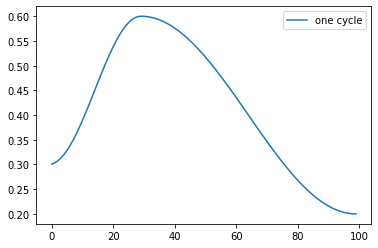

In [29]:
plt.plot(a, [sched(o) for o in p], label='one cycle')
plt.legend();

**Cosine one-cycle schedules:**

1. The first few epochs matter: things are sensitive, take small steps to get you to a good part of the loss landscape.
2. Now that we are in a good part of the loss landscape, we warm up: you need to train for a long time with a high lr to get good generalization.
3. In the end you need to cool down and fine-tune with a small lr for a long time.

Let's train with our new Schedulers:

In [103]:
cbfs = [Recorder,
        partial(AvgStatsCallback, accuracy),
        partial(ParamScheduler, 'lr', sched)]

In [104]:
learn = create_learner(get_model_func(0.3), loss_func, data)
run_with = Runner(cb_funcs=cbfs)

In [105]:
run_with.fit(3, learn)

train: [0.78135703125, tensor(0.7789)]
valid: [0.3868945068359375, tensor(0.8797)]
train: [0.30198333984375, tensor(0.9121)]
valid: [0.233548095703125, tensor(0.9336)]
train: [0.2356641796875, tensor(0.9326)]
valid: [0.2108467041015625, tensor(0.9410)]


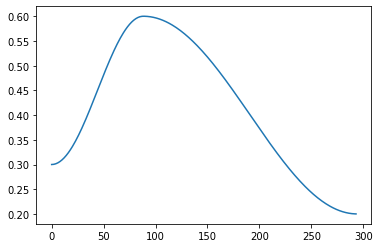

In [106]:
run_with.recorder.plot_lr()

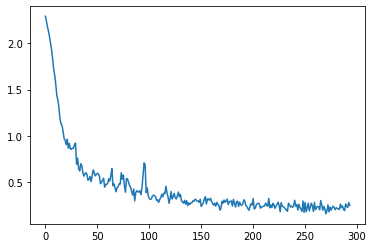

In [107]:
run_with.recorder.plot_loss()

In [109]:
run_with.recorder.losses[-1]

tensor(0.2492)

**In comparison without one-cycle lr scheduling:**

In [110]:
cbfs = [Recorder,
        partial(AvgStatsCallback, accuracy)]

In [111]:
learn = create_learner(get_model_func(0.3), loss_func, data)
run_without = Runner(cb_funcs=cbfs)

In [112]:
run_without.fit(3, learn)

train: [0.768639375, tensor(0.7988)]
valid: [0.34785791015625, tensor(0.9035)]
train: [0.34402734375, tensor(0.9019)]
valid: [0.284615771484375, tensor(0.9202)]
train: [0.29406751953125, tensor(0.9172)]
valid: [0.2796877685546875, tensor(0.9195)]


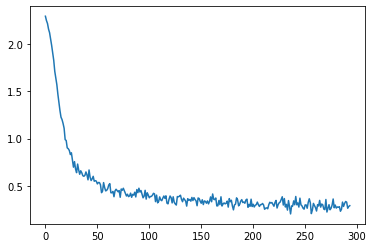

In [113]:
run_without.recorder.plot_loss()

**See that the rather large jumps are missing? Important because in the large lr learning phase we jump around to other local minima in the loss landscape. This is crucial for good generalization. Compare the final losses: much lower when using one-cylce learning rate scheduling!**

In [114]:
run_without.recorder.losses[-1]

tensor(0.2888)

In [115]:
steps = len(run_without.recorder.losses)
steps

294

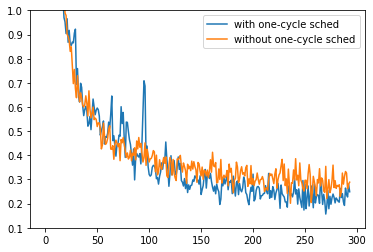

In [120]:
plt.plot(torch.arange(0, steps), run_with.recorder.losses, label="with one-cycle sched")
plt.plot(torch.arange(0, steps), run_without.recorder.losses, label='without one-cycle sched')
plt.ylim((0.1,1))
plt.legend();

## Export

In [121]:
!python notebook2script.py 05_anneal.ipynb

Converted 05_anneal.ipynb to exp/nb_05.py
